In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
np.object = np.object_
np.bool = np.bool_
np.int = int

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
# Load the cleaned data
df = pd.read_csv('cartItemsWithRating.csv')

In [8]:
df

,product_name,product_id,category_id,category,_id,status,is_order,is_payed,url_key,sku_from_system,...,store_name,cart_id,added_by,customer_id,user_id,brand_id,brand,product_url_key,product_description,rating
0,Propods P9 Wireless Gaming Headphones Ipx47,632adeebe387a0ccbd419f38,638590305a556431bf362c0a,1000 Ma Bazar,6369f4c9718f5cbc4c0eaab0,removed,False,False,propods-p9-wireless-gaming-headphones-ipx47,1378_105926346_NP-1027832760,...,Rk Jha Traders,6369f4c9718f5cbc4c0eaaaf,63295a1878f932890ebe7f33,63295a1878f932890ebe7f33,63295a1878f932890ebe7f33,5e2aa5e3bc8d203bec624d50,Not Applicable,propods-p9-wireless-gaming-headphones-ipx47,"<ul>\n\t<li data-spm-anchor-id=""a2a0e.pdp.prod...",3.0
1,Propods P9 Wireless Gaming Headphones Ipx47,632adeebe387a0ccbd419f38,638590305a556431bf362c0a,1000 Ma Bazar,636b55797e71f1fa8bd736b6,removed,False,False,propods-p9-wireless-gaming-headphones-ipx47,1378_105926346_NP-1027832760,...,Rk Jha Traders,636b55797e71f1fa8bd736b5,636b4ffd7e71f1fa8bd7356f,636b4ffd7e71f1fa8bd7356f,636b4ffd7e71f1fa8bd7356f,5e2aa5e3bc8d203bec624d50,Not Applicable,propods-p9-wireless-gaming-headphones-ipx47,"<ul>\n\t<li data-spm-anchor-id=""a2a0e.pdp.prod...",1.5
2,Propods P9 Wireless Gaming Headphones Ipx47,632adeebe387a0ccbd419f38,638590305a556431bf362c0a,1000 Ma Bazar,636ccaa7804ab22b48e0af07,removed,False,False,propods-p9-wireless-gaming-headphones-ipx47,1378_105926346_NP-1027832760,...,Rk Jha Traders,636ccaa7804ab22b48e0af06,6360e6483435d7cd920cdf24,6360e6483435d7cd920cdf24,6360e6483435d7cd920cdf24,5e2aa5e3bc8d203bec624d50,Not Applicable,propods-p9-wireless-gaming-headphones-ipx47,"<ul>\n\t<li data-spm-anchor-id=""a2a0e.pdp.prod...",1.5
3,Propods P9 Wireless Gaming Headphones Ipx47,632adeebe387a0ccbd419f38,638590305a556431bf362c0a,1000 Ma Bazar,636cdfeea5c31a2b645f6cc3,removed,False,False,propods-p9-wireless-gaming-headphones-ipx47,1378_105926346_NP-1027832760,...,Rk Jha Traders,636cdfeea5c31a2b645f6cc2,636cdf34804ab22b48e0b24c,636cdf34804ab22b48e0b24c,636cdf34804ab22b48e0b24c,5e2aa5e3bc8d203bec624d50,Not Applicable,propods-p9-wireless-gaming-headphones-ipx47,"<ul>\n\t<li data-spm-anchor-id=""a2a0e.pdp.prod...",2.5
4,Propods P9 Wireless Gaming Headphones Ipx47,632adeebe387a0ccbd419f38,638590305a556431bf362c0a,1000 Ma Bazar,636f07e31a01845aedc57ebb,removed,False,False,propods-p9-wireless-gaming-headphones-ipx47,1378_105926346_NP-1027832760,...,Rk Jha Traders,636f07d85458785af3fd9a9c,636f05e45458785af3fd9a78,636f05e45458785af3fd9a78,636f05e45458785af3fd9a78,5e2aa5e3bc8d203bec624d50,Not Applicable,propods-p9-wireless-gaming-headphones-ipx47,"<ul>\n\t<li data-spm-anchor-id=""a2a0e.pdp.prod...",2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663128,Barbie Bash Cake,5efad502ffc2a23ef854c288,5ef9ba85ffc2a23ef854a473,Cakes,608e794f27181703b5846eed,delivered,True,True,barbie-bash-cake,304_HC-B-31,...,Oho Cakes,607bfbcd28e4fd1f54fe4ee2,6076891500dfc2127dd65e12,6076891500dfc2127dd65e12,6076891500dfc2127dd65e12,5ef9db6effc2a23ef854b121,Oho Cake,barbie-bash-cake,<ul>\n\t<li>Pound 3 Pound</li>\n\t<li><strong>...,2.0
663129,Jeevan Jiune Kaida,5ef98fabffc2a23ef854950a,5ea9573765382e2f086c4cdb,Books,6097aa9c609139ec388b7a8c,delivered,True,True,jeevan-jiune-kaida,305_978-9937-8924-5-2,...,NEPALAYA,60979da2cf6664dd0319687e,60910407d462bf741b5c1569,60910407d462bf741b5c1569,60910407d462bf741b5c1569,5e2aa5e3bc8d203bec624d50,Not Applicable,jeevan-jiune-kaida,<ul>\n\t<li>Author: Jeevan Kumar Prasain</li>\...,1.5
663130,Palpasa Cafe Nepali,5ef98ef3ffc2a23ef85494fb,5eaa64de1b450532f9891eae,Books,60b33e5131642bf58d520d1e,delivered,True,True,palpasa-cafe-nepali,305_978-9937-9058-5-5,...,NEPALAYA,60b33dbf1487eff5642af542,NaN,NaN,NaN,5e2aa5e3bc8d203bec624d50,Not Applicable,palpasa-cafe-nepali,<ul>\n\t<li>Author: Narayan Wagle</li>\n\t<li>...,2.5
663131,Rookmangud Katawal (Nepali),5ef999adffc2a23ef854968b,5ea953fe65382e2f086c4ca1,Books,608bc0090fb8a98c32413fea,delivered,True,True,rookmangud-katawal-nepali,

In [13]:
# Encode product IDs
product_encoder = LabelEncoder()
df['product_id_encoded'] = product_encoder.fit_transform(df['product_id'])

# Encode user IDs
user_encoder = LabelEncoder()
df['customer_id_encoded'] = user_encoder.fit_transform(df['customer_id'])

In [14]:
# Create sequences of user interactions
def create_sequences(df, user_col, item_col, seq_length=5):
    sequences = []
    labels = []
    
    for user_id, group in df.groupby(user_col):
        items = group[item_col].tolist()
        if len(items) < seq_length:
            continue
        for i in range(len(items) - seq_length):
            sequences.append(items[i:i+seq_length])
            labels.append(items[i+seq_length])
    
    return np.array(sequences), np.array(labels)

In [15]:
seq_length = 5
X, y = create_sequences(df, 'customer_id_encoded', 'product_id_encoded', seq_length)
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### LSTM Model

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

def build_lstm_model(vocab_size, embed_dim, seq_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=seq_length))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dense(units=vocab_size, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

vocab_size = len(product_encoder.classes_)
embed_dim = 50
lstm_model = build_lstm_model(vocab_size, embed_dim, seq_length)
lstm_model.summary()

# Train the LSTM model
history_lstm = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5, 50)             1706050   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 34121)             2217865   
Total params: 3,953,355
Trainable params: 3,953,355
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
10213/10213 [==============================] - 53s 5ms/step - loss: 5.6689 - accuracy: 0.3435 - val_loss: 4.4152 - val_accuracy: 0.4950
Epoch 2/10
10213/10213 [==============================] - 81s 8ms/step - loss: 3.7873 - accuracy: 0.5486 - val_loss: 3.8710 - val_accuracy: 0.5731
Epoch 3/10
10213/10213 [==============================] - 171s 17ms/step - loss: 3

### GRU Model

In [17]:
from tensorflow.keras.layers import GRU

def build_gru_model(vocab_size, embed_dim, seq_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=seq_length))
    model.add(GRU(units=64, return_sequences=False))
    model.add(Dense(units=vocab_size, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

gru_model = build_gru_model(vocab_size, embed_dim, seq_length)
gru_model.summary()

# Train the GRU model
history_gru = gru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 50)             1706050   
_________________________________________________________________
gru (GRU)                    (None, 64)                22272     
_________________________________________________________________
dense_1 (Dense)              (None, 34121)             2217865   
Total params: 3,946,187
Trainable params: 3,946,187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
10213/10213 [==============================] - 49s 5ms/step - loss: 5.6977 - accuracy: 0.3306 - val_loss: 4.3375 - val_accuracy: 0.5151
Epoch 2/10
10213/10213 [==============================] - 48s 5ms/step - loss: 3.7223 - accuracy: 0.5673 - val_loss: 3.8622 - val_accuracy: 0.5865
Epoch 3/10
10213/10213 [==============================] - 47s 5ms/step - loss: 3

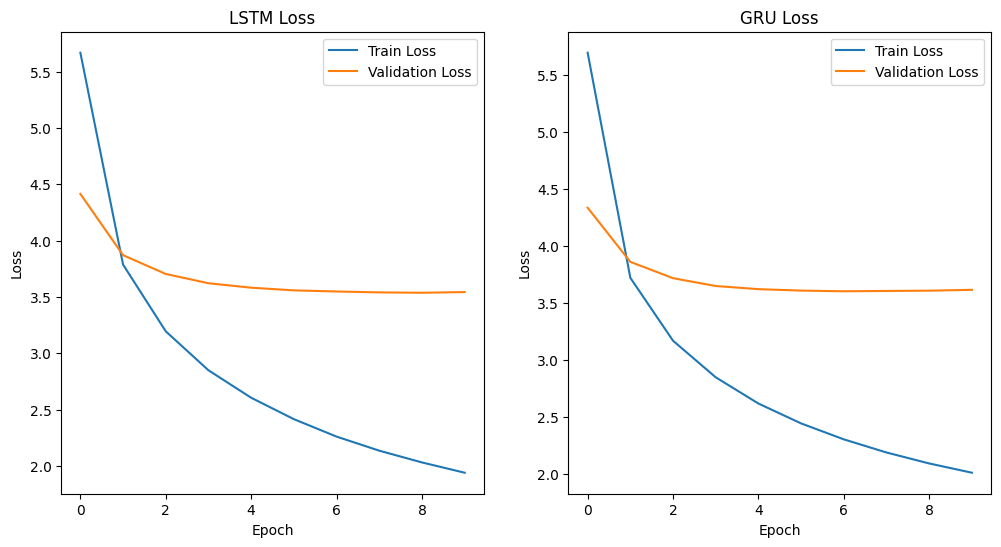

In [20]:
import matplotlib.pyplot as plt

# Plot training and validation loss for LSTM
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation loss for GRU
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


### Recommendation Code

In [23]:
def generate_recommendation_no_history(model, user_id, user_encoder, product_encoder, seq_length, top_n=5):
    """
    Generate top N product recommendations for a user without recent interaction history.

    Parameters:
    - model: Trained LSTM or GRU model.
    - user_id: The ID of the user for whom to generate recommendations.
    - user_encoder: Encoder used to transform user IDs.
    - product_encoder: Encoder used to transform product IDs.
    - seq_length: The sequence length used in model training.
    - top_n: Number of top recommendations to return.

    Returns:
    - List of top N recommended product IDs.
    """

    # Encode the user_id
    user_encoded = user_encoder.transform([user_id])

    # Create an empty sequence with just the user ID
    user_sequence = np.pad(user_encoded, (seq_length - len(user_encoded), 0), 'constant')
    
    # Reshape for model input
    user_sequence = user_sequence.reshape(1, seq_length)

    # Predict the next product
    predictions = model.predict(user_sequence)

    # Get the top N product indices
    top_n_indices = predictions.argsort()[0, -top_n:][::-1]

    # Decode the indices back to product IDs
    recommended_products = product_encoder.inverse_transform(top_n_indices)
    
    return recommended_products.tolist()

# Example usage
user_id = '63295a1878f932890ebe7f33'  # Replace with a real user ID

# Assume seq_length is the sequence length used in training, such as 5
seq_length = 5

# Generate recommendations
recommended_products = generate_recommendation_no_history(lstm_model, user_id, user_encoder, product_encoder, seq_length, top_n=5)

print("Top 5 product recommendations:", recommended_products)


Top 5 product recommendations: ['61dd1a7956b1cc02904423c0', '60a0e962f33020b1ae2c9234', '5feb22445ddc636b302e6f6f', '63045fd4c8fab7ff645b754e', '5e688cca7f1e0a4da1c073e9']


In [25]:
def generate_recommendation_no_history(model, user_id, user_encoder, product_encoder, seq_length, top_n=5):
    """
    Generate top N product recommendations for a user without recent interaction history.

    Parameters:
    - model: Trained LSTM or GRU model.
    - user_id: The ID of the user for whom to generate recommendations.
    - user_encoder: Encoder used to transform user IDs.
    - product_encoder: Encoder used to transform product IDs.
    - seq_length: The sequence length used in model training.
    - top_n: Number of top recommendations to return.

    Returns:
    - List of top N recommended product IDs.
    """

    # Encode the user_id
    user_encoded = user_encoder.transform([user_id])

    # Create an empty sequence with just the user ID
    user_sequence = np.pad(user_encoded, (seq_length - len(user_encoded), 0), 'constant')
    
    # Reshape for model input
    user_sequence = user_sequence.reshape(1, seq_length)

    # Predict the next product
    predictions = model.predict(user_sequence)

    # Get the top N product indices
    top_n_indices = predictions.argsort()[0, -top_n:][::-1]

    # Decode the indices back to product IDs
    recommended_products = product_encoder.inverse_transform(top_n_indices)
    
    return recommended_products.tolist()

# Example usage
user_id = '63295a1878f932890ebe7f33'  # Replace with a real user ID

# Assume seq_length is the sequence length used in training, such as 5
seq_length = 5

# Generate recommendations
recommended_products = generate_recommendation_no_history(lstm_model, user_id, user_encoder, product_encoder, seq_length, top_n=5)

print("Top 5 product recommendations:", recommended_products)


Top 5 product recommendations: ['61dd1a7956b1cc02904423c0', '60a0e962f33020b1ae2c9234', '5feb22445ddc636b302e6f6f', '63045fd4c8fab7ff645b754e', '5e688cca7f1e0a4da1c073e9']


In [26]:
def generate_recommendation_no_history(model, user_id, user_encoder, product_encoder, seq_length, top_n=5):
    """
    Generate top N product recommendations for a user without recent interaction history.

    Parameters:
    - model: Trained LSTM or GRU model.
    - user_id: The ID of the user for whom to generate recommendations.
    - user_encoder: Encoder used to transform user IDs.
    - product_encoder: Encoder used to transform product IDs.
    - seq_length: The sequence length used in model training.
    - top_n: Number of top recommendations to return.

    Returns:
    - List of top N recommended product IDs.
    """

    # Encode the user_id
    user_encoded = user_encoder.transform([user_id])

    # Create an empty sequence with just the user ID
    user_sequence = np.pad(user_encoded, (seq_length - len(user_encoded), 0), 'constant')
    
    # Reshape for model input
    user_sequence = user_sequence.reshape(1, seq_length)

    # Predict the next product
    predictions = model.predict(user_sequence)

    # Get the top N product indices
    top_n_indices = predictions.argsort()[0, -top_n:][::-1]

    # Decode the indices back to product IDs
    recommended_products = product_encoder.inverse_transform(top_n_indices)
    
    return recommended_products.tolist()

# Example usage
user_id = '63295a1878f932890ebe7f33'  # Replace with a real user ID

# Assume seq_length is the sequence length used in training, such as 5
seq_length = 5

# Generate recommendations
recommended_products = generate_recommendation_no_history(gru_model, user_id, user_encoder, product_encoder, seq_length, top_n=5)

print("Top 5 product recommendations:", recommended_products)


Top 5 product recommendations: ['5e67890c7f1e0a4da1c06c2a', '6044621d8b593f7655584373', '5f423b136a07b964402a78ef', '5e688cca7f1e0a4da1c073e9', '61713fb89df0ba62888c6031']
